# Wumpus World Unity Environment Log Analysis

This notebook contains our analysis of performance logs from different AI agent implementations in the Wumpus World Unity environment.

We compare execution times and behavioral patterns across multiple scenarios with varying complexity.

## Context

The analysis focuses on different AI types including:
- Basic Rule-based agents
- Finite State Machine agents
- Behavior Tree agents
- Prolog agents
- Prolog Meta Interpreter agents

Each scenario uses different configurations of world size, number of agents, and dangers (pits and Wumpus) distribution.

Common parameters across all configurations:
| Parameter | Value |
|:----------|:------|
| **randomSeed** | 1 |
| **nbGold** | 1 |
| **nbAgent** | [1, 5, 10] |
| **aiType** | [Basic, FiniteStateMachine, BehaviorTree, Prolog, PrologMetaInterpreter] |
| **personalities** | [(cupid & brave), (ascetic & coward), (cupid & coward)] |

### Grid-Specific Configurations

| Grid Size | Number of Pits & Wumpus |
|:---------:|:-------------:|
| 10x10     | 3          |
| 15x15     | 7          |
| 20x20     | 12         |
| 25x25     | 19         |
| 30x30     | 27         |
| 50x50     | 75         |
| 100x100   | 300        |

We have 7 grid sizes, 3 personality sets, 5 AI types, and 3 agent numbers.

So, there are `7*3*5*3=315` configurations.

### Data Collection

Files are stored in the `data` directory (same as this file). The data is organized in subdirectories based on the grid size:
- 10x10
- 15x15
- 20x20
- 25x25
- 30x30
- 50x50
- 100x100

Each json file follows the naming convention:
```
<grid_size>_<nb_agents>_<nb_wumpus_pits>_<nb_gold>_<personality1>_<personality2>_<ai_type>.json
```

For example, for a 10x10 grid with 1 agent, 3 wumpus, 3 pits, and 1 gold, using the Cupid and Coward personalities with a Basic AI type, the file would be in folder `10x10` under the name:
```
10x10/10x10-1a-3wp-1g-Cupid-Coward-Basic.json
```

### Data Structure

Each JSON file contains an array with two objects:

1. **Game Configuration and Performance Data**:
    - `randomSeed`: The seed used for randomization
    - `gridMin` & `gridMax`: Boundaries of the grid
    - `tileSize`: Size of each tile
    - `nbPit`, `nbWumpus`, `nbGold`: Number of pits, wumpuses, and gold
    - `nbAgent`: Number of agents
    - `aiType`: Type of AI used (Basic, Prolog, BehaviourTree, etc.)
    - `personalities`: Array of personality type IDs
    - `isGameOver`: Whether the game has ended
    - `isModeAuto`: Whether the game is running in automatic mode
    - `turnDuration`: Array of turn durations in milliseconds

2. **Agent Behavior Data**:
    - `agent`: Agent identifier
    - `actions`: Array of actions taken by the agent
    - `positions`: Array of position objects, with x,y coordinates for each turn

See [10x10/10x10-1a-3wp-1g-Cupid-Coward-Basic.json](10x10/10x10-1a-3wp-1g-Cupid-Coward-Basic.json) for an example of the data structure.

## 1. Data Analysis

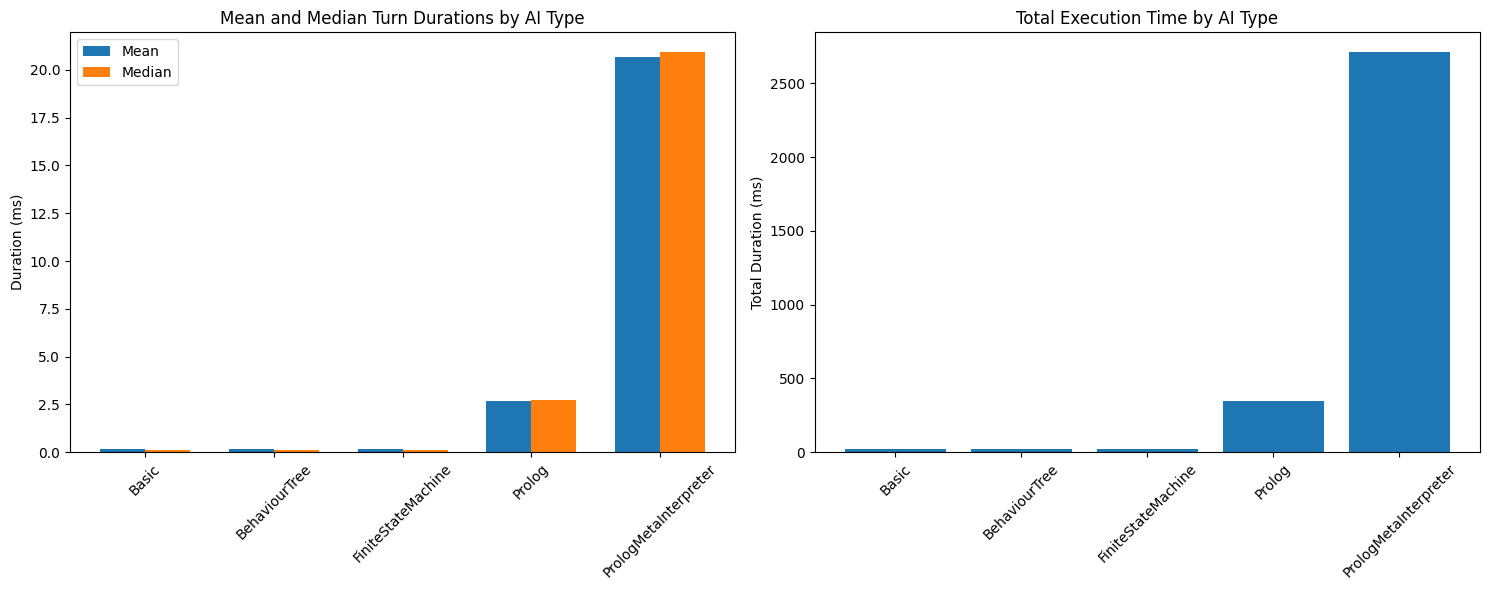

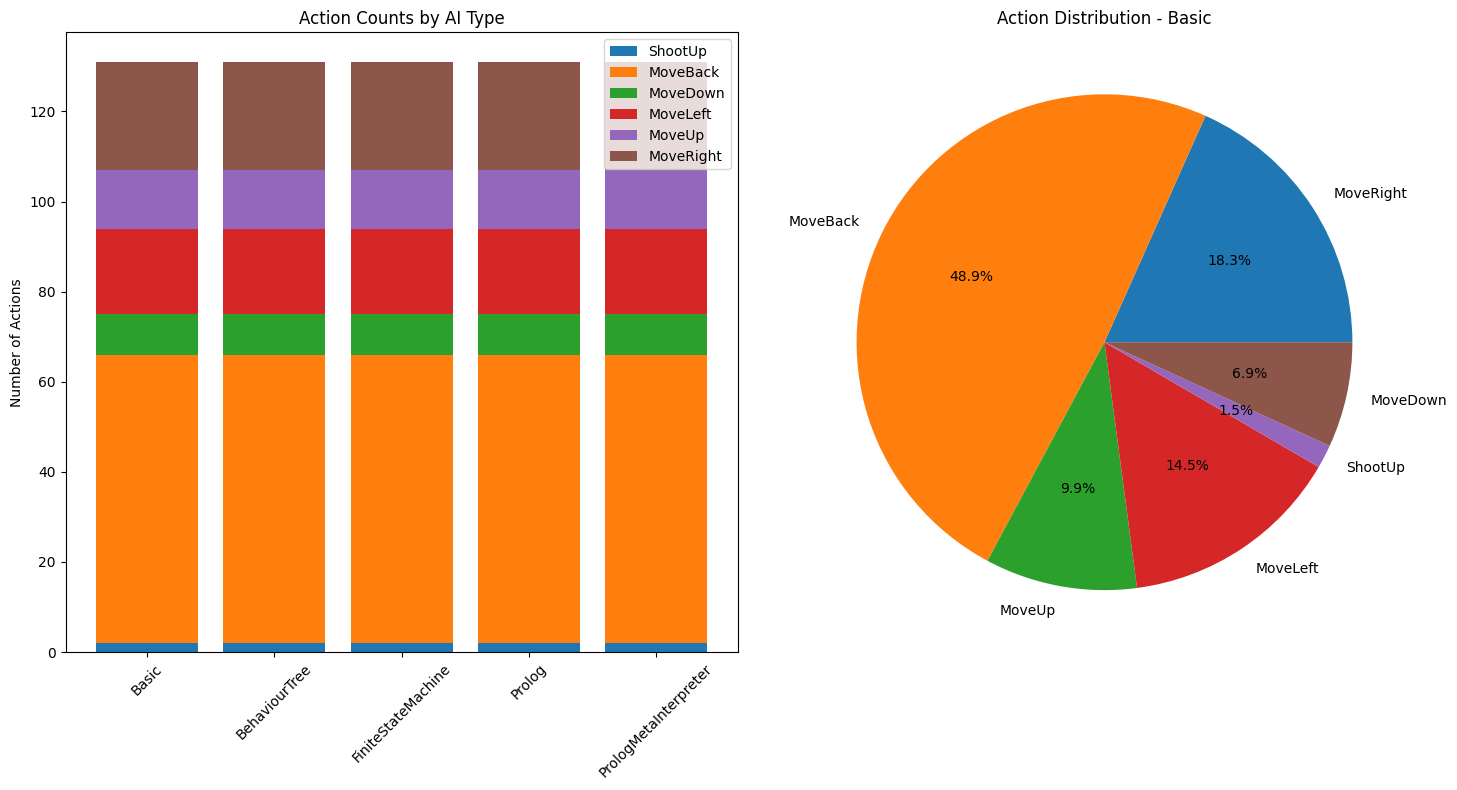

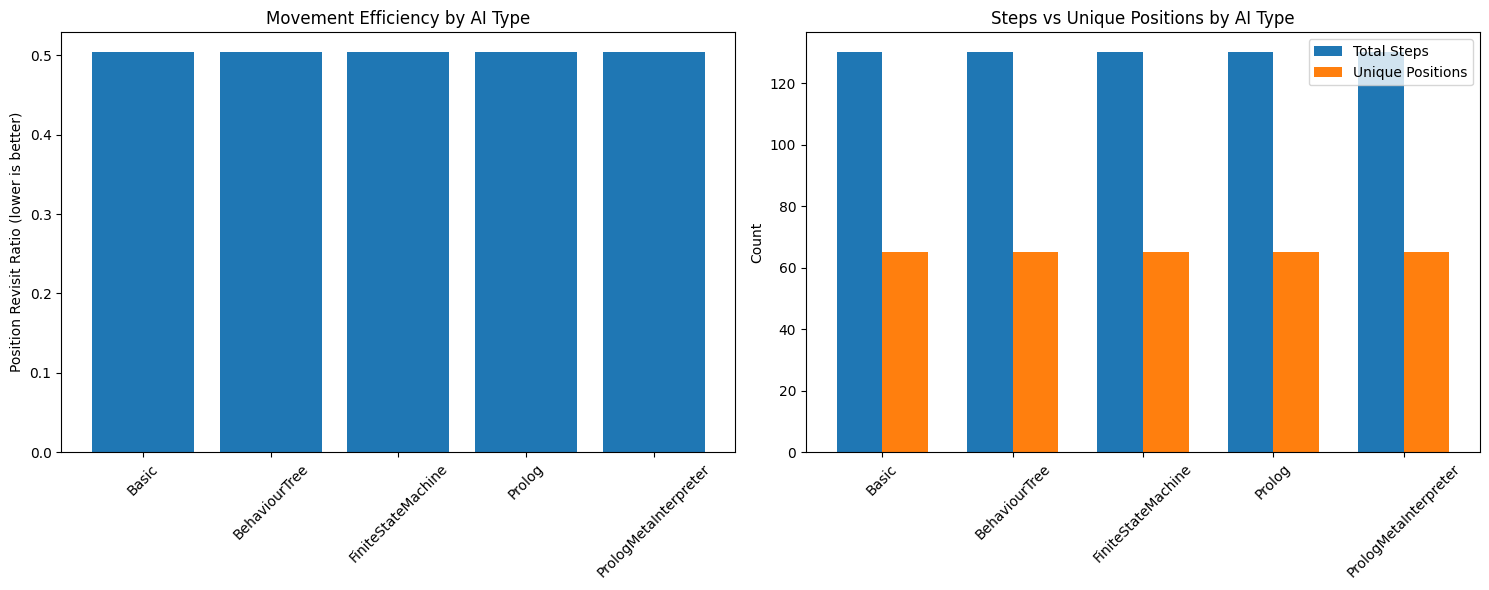

Summary of Key Metrics by AI Type:
--------------------------------------------------------------------------------
AI Type                   Mean Turn (ms)  Total Time (ms) Steps    Revisit Ratio  
--------------------------------------------------------------------------------
Basic                     0.1615          21.15           130      0.5038         
BehaviourTree             0.1673          21.91           130      0.5038         
FiniteStateMachine        0.1587          20.79           130      0.5038         
Prolog                    2.6633          348.89          130      0.5038         
PrologMetaInterpreter     20.6860         2709.87         130      0.5038         


In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Keep the existing functions
def load_json_data(file_path):
    """Load data from a JSON file."""
    with open(file_path, "r") as f:
        return json.load(f)

def get_turn_duration_stats(data):
    """Extract turn duration statistics from game data."""
    turn_durations = data[0]["turnDuration"]
    return {
        "mean": np.mean(turn_durations),
        "median": np.median(turn_durations),
        "min": np.min(turn_durations),
        "max": np.max(turn_durations),
        "std": np.std(turn_durations),
        "total": np.sum(turn_durations),
        "count": len(turn_durations),
    }

def analyze_agent_actions(data):
    """Analyze the frequency of different actions taken by agent."""
    actions = data[1]["actions"]
    action_counts = {}
    for action in actions:
        if action in action_counts:
            action_counts[action] += 1
        else:
            action_counts[action] = 1
    return action_counts

# Define function to calculate movement efficiency
def calculate_movement_efficiency(positions):
    total_steps = len(positions) - 1
    unique_positions = len(set((pos["x"], pos["y"]) for pos in positions))
    revisit_ratio = 1 - (unique_positions / len(positions))
    return {
        "total_steps": total_steps,
        "unique_positions": unique_positions,
        "revisit_ratio": revisit_ratio
    }

# Load data from all files
all_data = {}
all_stats = {}
for file_path in file_paths:
    # Extract AI type from filename
    ai_type = file_path.split('-')[-1].replace('.json', '')
    data = load_json_data(file_path)
    all_data[ai_type] = data
    
    # Collect stats for each AI type
    all_stats[ai_type] = {
        "turn_stats": get_turn_duration_stats(data),
        "action_counts": analyze_agent_actions(data),
        "movement_efficiency": calculate_movement_efficiency(data[1]["positions"])
    }

# Compare turn duration statistics across AI types
plt.figure(figsize=(15, 6))
ai_types = list(all_stats.keys())
mean_durations = [stats["turn_stats"]["mean"] for stats in all_stats.values()]
median_durations = [stats["turn_stats"]["median"] for stats in all_stats.values()]
max_durations = [stats["turn_stats"]["max"] for stats in all_stats.values()]
total_durations = [stats["turn_stats"]["total"] for stats in all_stats.values()]

# Bar chart for mean and median durations
plt.subplot(1, 2, 1)
x = np.arange(len(ai_types))
width = 0.35
plt.bar(x - width/2, mean_durations, width, label='Mean')
plt.bar(x + width/2, median_durations, width, label='Median')
plt.ylabel('Duration (ms)')
plt.title('Mean and Median Turn Durations by AI Type')
plt.xticks(x, ai_types, rotation=45)
plt.legend()

# Bar chart for total execution time
plt.subplot(1, 2, 2)
plt.bar(ai_types, total_durations)
plt.ylabel('Total Duration (ms)')
plt.title('Total Execution Time by AI Type')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Compare action frequencies across AI types
plt.figure(figsize=(15, 8))
all_action_types = set()
for stats in all_stats.values():
    all_action_types.update(stats["action_counts"].keys())
all_action_types = list(all_action_types)

# Create matrix for action counts
action_matrix = np.zeros((len(ai_types), len(all_action_types)))
for i, ai_type in enumerate(ai_types):
    for j, action in enumerate(all_action_types):
        action_matrix[i, j] = all_stats[ai_type]["action_counts"].get(action, 0)

# Plot stacked bar chart
plt.subplot(1, 2, 1)
bottom = np.zeros(len(ai_types))
for j, action in enumerate(all_action_types):
    plt.bar(ai_types, action_matrix[:, j], bottom=bottom, label=action)
    bottom += action_matrix[:, j]
plt.title('Action Counts by AI Type')
plt.ylabel('Number of Actions')
plt.xticks(rotation=45)
plt.legend(loc='upper right')

# Plot action distributions as pie charts
plt.subplot(1, 2, 2)
# Use first AI type's action distribution for the pie chart
action_counts = all_stats[ai_types[0]]["action_counts"]
plt.pie(action_counts.values(), labels=action_counts.keys(), autopct='%1.1f%%')
plt.title(f'Action Distribution - {ai_types[0]}')

plt.tight_layout()
plt.show()

# Compare movement efficiency metrics
plt.figure(figsize=(15, 6))
revisit_ratios = [stats["movement_efficiency"]["revisit_ratio"] for stats in all_stats.values()]
total_steps = [stats["movement_efficiency"]["total_steps"] for stats in all_stats.values()]
unique_positions = [stats["movement_efficiency"]["unique_positions"] for stats in all_stats.values()]

# Plot revisit ratios
plt.subplot(1, 2, 1)
plt.bar(ai_types, revisit_ratios)
plt.ylabel('Position Revisit Ratio (lower is better)')
plt.title('Movement Efficiency by AI Type')
plt.xticks(rotation=45)

# Plot steps vs unique positions
plt.subplot(1, 2, 2)
x = np.arange(len(ai_types))
width = 0.35
plt.bar(x - width/2, total_steps, width, label='Total Steps')
plt.bar(x + width/2, unique_positions, width, label='Unique Positions')
plt.ylabel('Count')
plt.title('Steps vs Unique Positions by AI Type')
plt.xticks(x, ai_types, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Create a summary table of key metrics
print("Summary of Key Metrics by AI Type:")
print("-" * 80)
print(f"{'AI Type':<25} {'Mean Turn (ms)':<15} {'Total Time (ms)':<15} {'Steps':<8} {'Revisit Ratio':<15}")
print("-" * 80)
for ai_type in ai_types:
    stats = all_stats[ai_type]
    print(f"{ai_type:<25} {stats['turn_stats']['mean']:<15.4f} {stats['turn_stats']['total']:<15.2f} {stats['movement_efficiency']['total_steps']:<8} {stats['movement_efficiency']['revisit_ratio']:<15.4f}")
